In [ ]:
! pip install pandas duckdb matplotlib seaborn --upgrade

# Imports

In [2]:
# Bibliotecas padrão
import os
import pathlib
import re
import shutil
from datetime import datetime
from glob import glob

# Bibliotecas de terceiros
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from pysus import SIA
from tqdm import tqdm

# Configurações iniciais
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')

In [3]:
sia = SIA().load()

In [4]:
procedimentos=pd.read_excel('TD_Tab_SUS_Anexos_Repositorio_IPEA_Revisto_14_de_agosto_de_2023.xlsx', skiprows=3, 
                            dtype={'Código formato numérico':str, 'Código':str} )
procedimentos['Nome']=procedimentos['Nome'].str.title()

dic_cid10=pd.read_csv('CID-10-SUBCATEGORIAS.CSV',
                      encoding='latin1', sep=';')

proc_ids = [
    "0301070083", "0301010030", "0301010048", "0301070067", "0301060045",
    "0301070121", "0301010072", "0301060096", "0302060049", "0301010064",
    "0301060029", "0301070075", "0301070105", "0301080011", "0301010137",
    "0301060061", "0301010161", "0301080178", "0301080143", "0301010056",
    "0301060100", "0301080160",
]


def medias_10m(filepath, pivot="2024-05"):
    """
    Lê um CSV cujo nome segue o padrão CODIGO_Cidade.csv e devolve:
      cidade, media_antes, media_depois, diferenca_bruta, diferenca_percentual
    
    • pré  = 10 meses imediatamente ANTES do mês-pivô (exclui o pivô)  
    • pós  = 10 meses a partir do mês-pivô (inclui o pivô)

    A coluna com datas deve chamar-se `ano_mes` (YYYY-MM)  
    A coluna com contagens deve chamar-se `n`.
    """
    # --- 0. Nome da cidade -----------------------------------------------
    cidade = os.path.splitext(os.path.basename(filepath))[0].split("-", 1)[1]

    # --- 1. Dados ---------------------------------------------------------
    df = pd.read_csv(filepath)
    df["period"] = pd.to_datetime(df["ano_mes"]).dt.to_period("M")

    # --- 2. Conjuntos pré e pós ------------------------------------------
    pivot_per = pd.Period(pivot, freq="M")
    pre_periods  = pd.period_range(end=pivot_per - 1, periods=10, freq="M")
    post_periods = pd.period_range(start=pivot_per,  periods=10, freq="M")

    # --- 3. Médias --------------------------------------------------------
    media_antes  = df.loc[df["period"].isin(pre_periods),  "n"].mean()
    media_depois = df.loc[df["period"].isin(post_periods), "n"].mean()

    # --- 4. Diferenças ----------------------------------------------------
    diff_abs = media_depois - media_antes
    diff_pct = np.nan if (pd.isna(media_antes) or media_antes == 0) else (diff_abs / media_antes) * 100

    return {
        "cidade": cidade,
        "media_antes": round(media_antes, 2),
        "media_depois": round(media_depois, 2),
        "diferenca_bruta": round(diff_abs, 2),
        "diferenca_percentual": round(diff_pct, 2),
    }


# SIA

## ETL - BI - Ambulatorial

In [18]:
# 1) lista de arquivos RD-RS 2010-2025
arquivos_bi =[] 
for ano in range(2015, 2026):
    temp1 = sia.get_files("BI", year=ano, uf="RS")
    for x in temp1:
        arquivos_bi.append(x)

In [ ]:
# ------- setup -------------------------------------------------------------
out_dir = pathlib.Path("bpa_saude_mental_rs")   # destino dos parquets filtrados
if out_dir.exists():
    shutil.rmtree(out_dir)     # limpa se quiser recomeçar
out_dir.mkdir()

cid_regex = re.compile(r"^F")      # qualquer F00–F99

# -------- loop com barra de progresso -------------------------------------
for src, pset in tqdm(zip(arquivos_bi, sia.download(arquivos_bi)),
                      total=len(arquivos_bi), desc="Processando BI"):
    tqdm.write(f"➜ {src}")         # exibe qual arquivo está em uso

    df = pset.to_dataframe()
    df = df[df["CIDPRI"].astype(str).str.match(cid_regex)]
    if df.empty:
        continue

    # corrige AAAAMM vs AAAAMMDD
    s = df["DT_ATEND"].astype(str)
    s = s.where(s.str.len() == 8, s + "01")
    df["ano_mes"] = (
        pd.to_datetime(s, format="%Y%m%d")
          .dt.to_period("M")
          .astype(str)
    )

    tbl = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        tbl,
        root_path=out_dir,
        partition_cols=["ano_mes"],
        existing_data_behavior="overwrite_or_ignore"
    )
    del df, tbl

print("Dataset incremental salvo em", out_dir)

## Análise - BI - Ambulatorial

#### Setup

In [ ]:
con = duckdb.connect()
con.execute("PRAGMA memory_limit='10GB';")   # never exceeds 10 GB incl. OS cache

DATA_DIR = Path("bpa_saude_mental_rs").absolute()

con.execute(f"""
    CREATE VIEW mental AS
    SELECT * FROM
    parquet_scan('{DATA_DIR}/**/*.parquet',
                 hive_partitioning=true)   -- picks up ano_mes=
""")

#### 1. Visão geral

In [ ]:
total_amb = con.execute("""
    SELECT 
        COUNT(*) AS total_registros, 
        MIN(ano_mes) AS periodo_inicial, 
        MAX(ano_mes) AS periodo_final 
    FROM mental 
""").df()

print(total_amb)

In [ ]:
# Consulta para contar registros e obter período inicial e final, filtrados pelos procedimentos específicos
cont_amb = con.execute("""
    SELECT 
        COUNT(*) AS total_registros, 
        MIN(ano_mes) AS periodo_inicial, 
        MAX(ano_mes) AS periodo_final 
    FROM mental 
    WHERE PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
""").df()

print(cont_amb)

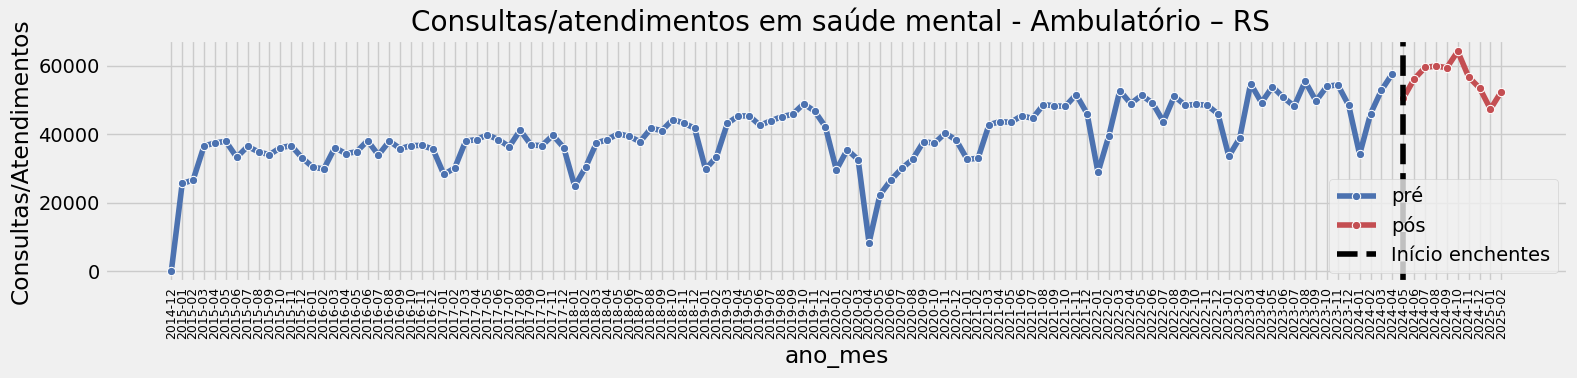

In [8]:
serie = con.execute("""
    WITH t AS (
      SELECT
        ano_mes,
        COUNT(*) AS n
      FROM mental
      WHERE PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
      GROUP BY 1
    )
    SELECT
      ano_mes,
      n,
      CASE WHEN ano_mes >= '2024-05' THEN 'pós' ELSE 'pré' END AS periodo
    FROM t
    ORDER BY ano_mes;
""").df()

plt.figure(figsize=(16,4))
sns.lineplot(data=serie, x="ano_mes", y="n", hue="periodo",
             palette={"pré":"#4C72B0", "pós":"#C44E52"}, marker="o")
plt.xticks(rotation=90, fontsize=9)
plt.axvline("2024-05", color="black", ls="--", label="Início enchentes")
plt.ylabel("Consultas/Atendimentos"); plt.title(" Consultas/atendimentos em saúde mental - Ambulatório – RS")
plt.legend(); plt.tight_layout(); plt.show()


#### 2. Por municípios - média de procedimentos antes e depois das enchentes

In [ ]:
# Carrega a lista de municípios
municipios = pd.read_csv('municipios_RS.csv')

# Cria pasta de saída se não existir
output_dir = "resultados_municipios_AMB"
os.makedirs(output_dir, exist_ok=True)

# Loop por todos os municípios
for index, row in tqdm(municipios.iterrows(), total=len(municipios)):
    cod = str(row["id_municipio_6"])
    nome = row["nome"].replace("/", "-").replace(" ", "_")
    filename_base = f"{cod}_{nome}"

    # Executa a query
    atendimentos_temp = con.execute(f"""
        WITH t AS (
            SELECT
                ano_mes,
                COUNT(*) AS n
            FROM mental
            WHERE MUNPAC = '{cod}'
            AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
            GROUP BY 1
        )
        SELECT
            ano_mes,
            n,
            CASE WHEN ano_mes >= '2024-05' THEN 'pós' ELSE 'pré' END AS periodo
        FROM t
        ORDER BY ano_mes;
    """).df()

    # Salva a tabela CSV
    csv_path = os.path.join(output_dir, f"{filename_base}.csv")
    atendimentos_temp.to_csv(csv_path, index=False)

    # Cria o gráfico
    plt.figure(figsize=(16, 4))
    sns.lineplot(data=atendimentos_temp, x="ano_mes", y="n", hue="periodo",
                 palette={"pré": "#4C72B0", "pós": "#C44E52"}, marker="o")
    plt.xticks(rotation=90, fontsize=9)
    plt.axvline("2024-05", color="black", ls="--", label="Início enchentes")
    plt.ylabel("Consultas/Atendimentos")
    plt.title(f"Consultas/atendimentos em saúde mental AMB – {row['nome']}")
    plt.legend()
    plt.tight_layout()

    # Salva o gráfico
    png_path = os.path.join(output_dir, f"{filename_base}.png")
    plt.savefig(png_path)
    plt.close()

    
    

In [ ]:
cidades_AMB=[]
for arquivo in tqdm(glob.glob('resultados_municipios_AMB/*.csv')):
    temp=medias_10m(arquivo)
    cidades_AMB.append(temp)
    
pd.DataFrame(cidades_AMB).sort_values('diferenca_percentual', ascending=False).to_csv('variação_cidade_AMB.csv')

#### 3. Por municípios - variação CID por município

In [ ]:
# Carrega a lista de municípios
municipios = pd.read_csv('municipios_RS.csv')

# Cria pasta de saída se não existir
output_dir = "diag_municipios_AMB"
os.makedirs(output_dir, exist_ok=True)

# Loop por todos os municípios
for index, row in tqdm(municipios.iterrows(), total=len(municipios)):
    cod = str(row["id_municipio_6"])
    nome = row["nome"].replace("/", "-").replace(" ", "_")
    filename_base = f"{cod}_{nome}"

    # Executa a query
    diag_amb=con.execute(f"""
    WITH 
    antes_enchente AS (
    SELECT 
        CIDPRI AS classe_cid,
        COUNT(*) AS contagem,
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM mental WHERE ano_mes < '2024-05' AND ano_mes >= '2023-07' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')) AS media_mensal
    FROM mental
    WHERE ano_mes >= '2023-07' AND ano_mes < '2024-05' AND MUNPAC = '{cod}' 
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
    GROUP BY classe_cid
    ),
    depois_enchente AS (
    SELECT 
        CIDPRI AS classe_cid,
        COUNT(*) AS contagem,
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM mental WHERE ano_mes >= '2024-05' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')) AS media_mensal

    FROM mental
    WHERE ano_mes >= '2024-05' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
    GROUP BY classe_cid
    )
    SELECT 
    COALESCE(a.classe_cid, d.classe_cid) AS classe_cid,
    a.media_mensal AS media_antes,
    d.media_mensal AS media_depois,
    COALESCE(d.media_mensal, 0) - COALESCE(a.media_mensal, 0) AS variacao_absoluta,
    CASE 
        WHEN a.media_mensal > 0 
        THEN ((COALESCE(d.media_mensal, 0) - a.media_mensal) / a.media_mensal) * 100 
        ELSE NULL 
    END AS variacao_percentual
    FROM antes_enchente a
    FULL OUTER JOIN depois_enchente d ON a.classe_cid = d.classe_cid
    WHERE a.contagem >= 5 OR d.contagem >= 5
    ORDER BY variacao_percentual DESC NULLS LAST;
    """).df()

    # Salva a tabela CSV
    csv_path = os.path.join(output_dir, f"diag_AMB_{filename_base}.csv")
    diag_amb.to_csv(csv_path, index=False)

# ---------- 1. localizar todos os CSVs gerados -----------------------------
DIR_IN   = pathlib.Path("diag_municipios_AMB")
DIR_OUT  = pathlib.Path("diag_municipios_AMB")
PARQUET  = DIR_OUT / "diagnosticos_AMB_RS_tidy.parquet"
CSV_OUT  = DIR_OUT / "diagnosticos_AMB_RS_tidy.csv"

arquivos = glob.glob(str(DIR_IN / "diag_AMB*.csv"))

# ---------- 2. leitura incremental e empilhamento -------------------------
dfs = []

for path in tqdm(arquivos):
    # extrai código e nome do município do nome do arquivo
    # padrão: diag_F_<cod>_<nome>.csv
    fname = pathlib.Path(path).stem
    m = re.match(r"diag_AMB_(\d{6})_(.+)", fname)
    if not m:
        continue
    cod_mun, nome_mun = m.groups()

    df = pd.read_csv(path)
    df.insert(0, "municipio_id", cod_mun)
    df.insert(1, "municipio_nome", nome_mun.replace("_", " "))

    dfs.append(df)

# concatena tudo em formato tidy
final = pd.concat(dfs, ignore_index=True)

final=final.merge(dic_cid10[['SUBCAT','DESCRICAO']], left_on='classe_cid', right_on='SUBCAT',how='inner')
final.to_parquet(PARQUET, index=False)
final.to_csv(CSV_OUT, index=False)

#### 4. Análise por diagnóstico

In [ ]:
diag_por_cid = con.execute("""
-- Comparação de diagnósticos (CIDs) antes e depois das enchentes, filtrando por procedimentos específicos
WITH
antes_enchente AS (
  SELECT
    CIDPRI,
    COUNT(*) AS contagem,
    COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM mental 
                WHERE ano_mes < '2024-05' AND ano_mes >= '2023-07' 
                AND PROC_ID IN (
                  '0301070083', '0301010030', '0301010048', '0301070067', '0301060045',
                  '0301070121', '0301010072', '0301060096', '0302060049', '0301010064',
                  '0301060029', '0301070075', '0301070105', '0301080011', '0301010137',
                  '0301060061', '0301010161', '0301080178', '0301080143', '0301010056',
                  '0301060100', '0301080160'
                )) AS media_mensal
  FROM mental
  WHERE ano_mes >= '2023-07' AND ano_mes < '2024-05' 
  AND PROC_ID IN (
    '0301070083', '0301010030', '0301010048', '0301070067', '0301060045',
    '0301070121', '0301010072', '0301060096', '0302060049', '0301010064',
    '0301060029', '0301070075', '0301070105', '0301080011', '0301010137',
    '0301060061', '0301010161', '0301080178', '0301080143', '0301010056',
    '0301060100', '0301080160'
  )
  GROUP BY CIDPRI
),
depois_enchente AS (
  SELECT
    CIDPRI,
    COUNT(*) AS contagem,
    COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM mental 
                WHERE ano_mes >= '2024-05' 
                AND PROC_ID IN (
                  '0301070083', '0301010030', '0301010048', '0301070067', '0301060045',
                  '0301070121', '0301010072', '0301060096', '0302060049', '0301010064',
                  '0301060029', '0301070075', '0301070105', '0301080011', '0301010137',
                  '0301060061', '0301010161', '0301080178', '0301080143', '0301010056',
                  '0301060100', '0301080160'
                )) AS media_mensal
  FROM mental
  WHERE ano_mes >= '2024-05'
  AND PROC_ID IN (
    '0301070083', '0301010030', '0301010048', '0301070067', '0301060045',
    '0301070121', '0301010072', '0301060096', '0302060049', '0301010064',
    '0301060029', '0301070075', '0301070105', '0301080011', '0301010137',
    '0301060061', '0301010161', '0301080178', '0301080143', '0301010056',
    '0301060100', '0301080160'
  )
  GROUP BY CIDPRI
)
SELECT
  COALESCE(a.CIDPRI, d.CIDPRI) AS CIDPRI,
  a.contagem AS contagem_antes,
  d.contagem AS contagem_depois,
  a.media_mensal AS media_antes,
  d.media_mensal AS media_depois,
  COALESCE(d.media_mensal, 0) - COALESCE(a.media_mensal, 0) AS variacao_absoluta,
  CASE
    WHEN a.media_mensal > 0
    THEN ((COALESCE(d.media_mensal, 0) - a.media_mensal) / a.media_mensal) * 100
    ELSE NULL
  END AS variacao_percentual
FROM antes_enchente a
FULL OUTER JOIN depois_enchente d ON a.CIDPRI = d.CIDPRI
WHERE a.contagem >= 5 OR d.contagem >= 5  -- Filtrando diagnósticos raros
ORDER BY variacao_percentual DESC NULLS LAST;
""").df()

In [ ]:
diag_por_cid=diag_por_cid.merge(dic_cid10[['SUBCAT','DESCRICAO']], left_on='CIDPRI', right_on='SUBCAT',how='inner')

## ETL - PS - CAPS

In [19]:
arquivos_ps =[] 
for ano in range(2015, 2026):
    temp2 = sia.get_files("PS", year=ano, uf="RS")
    for x in temp2:
        arquivos_ps.append(x)

In [ ]:
# ------- setup -------------------------------------------------------------
out_dir = pathlib.Path("raas_caps_rs")   # destino dos parquets filtrados
if out_dir.exists():
    shutil.rmtree(out_dir)     # limpa se quiser recomeçar
out_dir.mkdir()

sia = SIA().load()

# Define o padrão para pegar diagnósticos de transtornos mentais (CID F00–F99)
cid_regex = re.compile(r"^F")

# -------- loop com barra de progresso -------------------------------------
for src, pset in tqdm(zip(arquivos_ps, sia.download(arquivos_ps)),
                      total=len(arquivos_ps), desc="Processando RAAS"):
    tqdm.write(f"➜ {src}")         # exibe qual arquivo está em uso

    df = pset.to_dataframe()

    if "TP_UNID_ASSIST" in df.columns:
        df = df[df["TP_UNID_ASSIST"].isin(["01", "02", "03", "04", "05", "06", "07"])]  

    # Aplica filtro CID F
    if "CIDPRI" in df.columns:
        df = df[df["CIDPRI"].astype(str).str.match(cid_regex)]

    if df.empty:
        continue

    # Corrige AAAAMM vs AAAAMMDD para a coluna de data de atendimento
    if "DT_ATEND" in df.columns:
        s = df["DT_ATEND"].astype(str)
        s = s.where(s.str.len() == 8, s + "01")
        df["ano_mes"] = (
            pd.to_datetime(s, format="%Y%m%d", errors="coerce")
              .dt.to_period("M")
              .astype(str)
        )
    else:
        df["ano_mes"] = "desconhecido"

    # Salva o arquivo parquet particionado
    tbl = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        tbl,
        root_path=out_dir,
        partition_cols=["ano_mes"],
        existing_data_behavior="overwrite_or_ignore"
    )
    del df, tbl

print("Dataset incremental salvo em", out_dir)


## Análise - PS - CAPS

#### Setup

In [ ]:
con = duckdb.connect()
con.execute("PRAGMA memory_limit='10GB';")   # never exceeds 10 GB incl. OS cache

DATA_DIR = Path("raas_caps_rs").absolute()

con.execute(f"""
    CREATE VIEW caps AS
    SELECT * FROM
    parquet_scan('{DATA_DIR}/**/*.parquet',
                 hive_partitioning=true)   -- picks up ano_mes=
""")

#### 1. Visão geral

In [ ]:
total_cap = con.execute("""
    SELECT 
        COUNT(*) AS total_registros, 
        MIN(ano_mes) AS periodo_inicial, 
        MAX(ano_mes) AS periodo_final 
    FROM caps 
""").df()

print(total_cap)

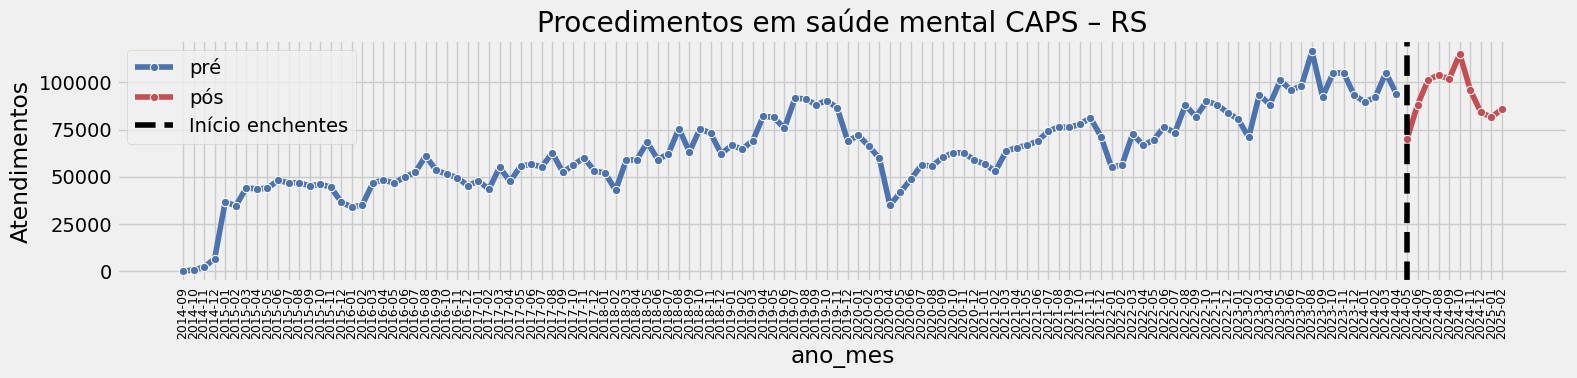

In [8]:
atendimentos_temp = con.execute("""
    WITH t AS (
      SELECT
        ano_mes,
        COUNT(*) AS n
      FROM caps

      GROUP BY 1
    )
    SELECT
      ano_mes,
      n,
      CASE WHEN ano_mes >= '2024-05' THEN 'pós' ELSE 'pré' END AS periodo
    FROM t
    ORDER BY ano_mes;
""").df()

plt.figure(figsize=(16,4))
sns.lineplot(data=atendimentos_temp, x="ano_mes", y="n", hue="periodo",
             palette={"pré":"#4C72B0", "pós":"#C44E52"}, marker="o")
plt.xticks(rotation=90, fontsize=9)
plt.axvline("2024-05", color="black", ls="--", label="Início enchentes")
plt.ylabel("Atendimentos"); plt.title("Procedimentos em saúde mental CAPS – RS")
plt.legend(); plt.tight_layout(); plt.show()


#### 2. Por municípios - média de procedimentos antes e depois das enchentes


In [ ]:
# Carrega a lista de municípios
municipios = pd.read_csv('municipios_RS.csv')

# Cria pasta de saída se não existir
output_dir = "resultados_municipios_CAPS"
os.makedirs(output_dir, exist_ok=True)

# Loop por todos os municípios
for index, row in tqdm(municipios.iterrows(), total=len(municipios)):
    cod = str(row["id_municipio_6"])
    nome = row["nome"].replace("/", "-").replace(" ", "_")
    filename_base = f"{cod}_{nome}"

    # Executa a query
    atendimentos_temp = con.execute(f"""
        WITH t AS (
            SELECT
                ano_mes,
                COUNT(*) AS n
            FROM caps
            WHERE MUNPAC = '{cod}'
            GROUP BY 1
        )
        SELECT
            ano_mes,
            n,
            CASE WHEN ano_mes >= '2024-05' THEN 'pós' ELSE 'pré' END AS periodo
        FROM t
        ORDER BY ano_mes;
    """).df()

    # Salva a tabela CSV
    csv_path = os.path.join(output_dir, f"{filename_base}.csv")
    atendimentos_temp.to_csv(csv_path, index=False)

    # Cria o gráfico
    plt.figure(figsize=(16, 4))
    sns.lineplot(data=atendimentos_temp, x="ano_mes", y="n", hue="periodo",
                 palette={"pré": "#4C72B0", "pós": "#C44E52"}, marker="o")
    plt.xticks(rotation=90, fontsize=9)
    plt.axvline("2024-05", color="black", ls="--", label="Início enchentes")
    plt.ylabel("Atendimentos")
    plt.title(f"Prodecimentos em saúde mental CAPS – {row['nome']}")
    plt.legend()
    plt.tight_layout()

    # Salva o gráfico
    png_path = os.path.join(output_dir, f"{filename_base}.png")
    plt.savefig(png_path)
    plt.close()

cidades_CAPS=[]
for arquivo in tqdm(glob.glob('resultados_municipios_CAPS/*.csv')):
    temp=medias_10m(arquivo)
    cidades_CAPS.append(temp)
    
pd.DataFrame(cidades_CAPS).to_csv('variação_cidade_CAPS.csv')


#### 3. Por municípios - variação CID por município

In [ ]:
# Carrega a lista de municípios
municipios = pd.read_csv('municipios_RS.csv')

# Cria pasta de saída se não existir
output_dir = "diag_municipios_CAPS"
os.makedirs(output_dir, exist_ok=True)

# Loop por todos os municípios
for index, row in tqdm(municipios.iterrows(), total=len(municipios)):
    cod = str(row["id_municipio_6"])
    nome = row["nome"].replace("/", "-").replace(" ", "_")
    filename_base = f"{cod}_{nome}"

    # Executa a query
    diag_caps=con.execute(f"""
    WITH 
    antes_enchente AS (
    SELECT 
        CIDPRI AS classe_cid,
        COUNT(*) AS contagem,
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes < '2024-05' AND ano_mes >= '2023-07' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')) AS media_mensal
    FROM caps
    WHERE ano_mes >= '2023-07' AND ano_mes < '2024-05' AND MUNPAC = '{cod}' 
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
    GROUP BY classe_cid
    ),
    depois_enchente AS (
    SELECT 
        CIDPRI AS classe_cid,
        COUNT(*) AS contagem,
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes >= '2024-05' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')) AS media_mensal

    FROM caps
    WHERE ano_mes >= '2024-05' AND MUNPAC = '{cod}'
        AND PROC_ID IN (
        '0301070083', '0301010030', '0301010048', '0301070067', '0301060045', 
        '0301070121', '0301010072', '0301060096', '0302060049', '0301010064', 
        '0301060029', '0301070075', '0301070105', '0301080011', '0301010137', 
        '0301060061', '0301010161', '0301080178', '0301080143', '0301010056', 
        '0301060100', '0301080160')
    GROUP BY classe_cid
    )
    SELECT 
    COALESCE(a.classe_cid, d.classe_cid) AS classe_cid,
    a.media_mensal AS media_antes,
    d.media_mensal AS media_depois,
    COALESCE(d.media_mensal, 0) - COALESCE(a.media_mensal, 0) AS variacao_absoluta,
    CASE 
        WHEN a.media_mensal > 0 
        THEN ((COALESCE(d.media_mensal, 0) - a.media_mensal) / a.media_mensal) * 100 
        ELSE NULL 
    END AS variacao_percentual
    FROM antes_enchente a
    FULL OUTER JOIN depois_enchente d ON a.classe_cid = d.classe_cid
    WHERE a.contagem >= 5 OR d.contagem >= 5
    ORDER BY variacao_percentual DESC NULLS LAST;
    """).df()

    # Salva a tabela CSV
    csv_path = os.path.join(output_dir, f"diag_CAPS_{filename_base}.csv")
    diag_caps.to_csv(csv_path, index=False)

# ---------- 1. localizar todos os CSVs gerados -----------------------------
DIR_IN   = pathlib.Path("diag_municipios_CAPS")
DIR_OUT  = pathlib.Path("diag_municipios_CAPS")
PARQUET  = DIR_OUT / "diagnosticos_CAPS_RS_tidy.parquet"
CSV_OUT  = DIR_OUT / "diagnosticos_CAPS_RS_tidy.csv"

arquivos = glob.glob(str(DIR_IN / "diag_CAPS*.csv"))

# ---------- 2. leitura incremental e empilhamento -------------------------
dfs_CAPS = []

for path in tqdm(arquivos):
    # extrai código e nome do município do nome do arquivo
    # padrão: diag_F_<cod>_<nome>.csv
    fname = pathlib.Path(path).stem
    m = re.match(r"diag_CAPS_(\d{6})_(.+)", fname)
    if not m:
        continue
    cod_mun, nome_mun = m.groups()

    df = pd.read_csv(path)
    df.insert(0, "municipio_id", cod_mun)
    df.insert(1, "municipio_nome", nome_mun.replace("_", " "))

    dfs_CAPS.append(df)

# concatena tudo em formato tidy
final_CAPS = pd.concat(dfs_CAPS, ignore_index=True)

final_CAPS=final_CAPS.merge(dic_cid10[['SUBCAT','DESCRICAO']], left_on='classe_cid', right_on='SUBCAT',how='inner')
final_CAPS.to_parquet(PARQUET, index=False)
final_CAPS.to_csv(CSV_OUT, index=False)

#### 4. Análise por diagnóstico

In [9]:
diag_caps=con.execute("""
-- Top diagnósticos antes e depois das enchentes para o município 431490
WITH 
antes_enchente AS (
    SELECT 
        CIDPRI,
        COUNT(*) AS contagem,
        -- COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes < '2024-05' AND ano_mes >= '2023-07' AND MUNPAC = '431490') AS media_mensal
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes < '2024-05' AND ano_mes >= '2023-07') AS media_mensal
    FROM caps
    -- WHERE ano_mes >= '2023-07' AND ano_mes < '2024-05' AND MUNPAC = '431490'
    WHERE ano_mes >= '2023-07' AND ano_mes < '2024-05'
    GROUP BY CIDPRI
),
depois_enchente AS (
    SELECT 
        CIDPRI,
        COUNT(*) AS contagem,
        -- COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes >= '2024-05' AND MUNPAC = '431490') AS media_mensal
        COUNT(*) / (SELECT COUNT(DISTINCT ano_mes) FROM caps WHERE ano_mes >= '2024-05') AS media_mensal
    FROM caps
    -- WHERE ano_mes >= '2024-05' AND MUNPAC = '431490'
    WHERE ano_mes >= '2024-05'
    GROUP BY CIDPRI
)
SELECT 
    COALESCE(a.CIDPRI, d.CIDPRI) AS CIDPRI,
    a.media_mensal AS media_antes,
    d.media_mensal AS media_depois,
    COALESCE(d.media_mensal, 0) - COALESCE(a.media_mensal, 0) AS variacao_absoluta,
    CASE 
        WHEN a.media_mensal > 0 
        THEN ((COALESCE(d.media_mensal, 0) - a.media_mensal) / a.media_mensal) * 100 
        ELSE NULL 
    END AS variacao_percentual
FROM antes_enchente a
FULL OUTER JOIN depois_enchente d ON a.CIDPRI = d.CIDPRI
WHERE a.contagem >= 5 OR d.contagem >= 5  -- Filtrando diagnósticos raros
ORDER BY variacao_percentual DESC;
""").df()

diag_caps=diag_caps.merge(dic_cid10[['SUBCAT','DESCRICAO']], left_on='CIDPRI', right_on='SUBCAT',how='inner')
